In [3]:
from glob import glob
import numpy as np 
import pandas as pd
from tqdm import tqdm
import cv2
import warnings
warnings.filterwarnings('ignore')

import argparse
import gc
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from piece_detector import *

In [4]:
detector = Detector()


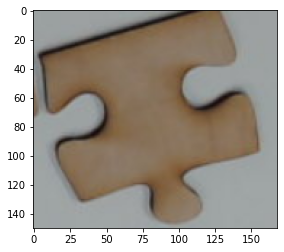

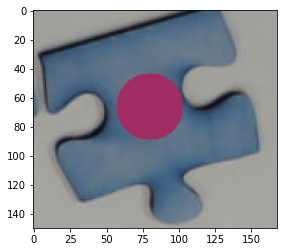

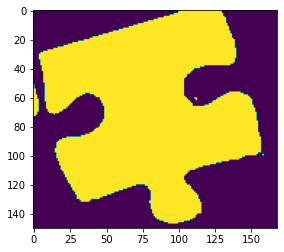

In [5]:
img1 = cv2.imread('p1.png')
plt.imshow(img1[:, :, ::-1])
plt.show()
plt.imshow(detector.process(img1.copy())[0])
plt.show()
img_m1 = detector.pieces[0].img
plt.imshow(img_m1)
plt.show()

In [6]:
threshold = 100
canny_output = cv2.Canny(img_m1, threshold, threshold * 2)
contours, hierarchy = cv2.findContours(img_m1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

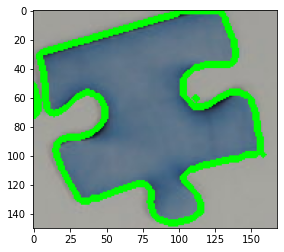

In [7]:
plt.imshow(cv2.drawContours(img1, contours, -1, (0,255,0), 3))

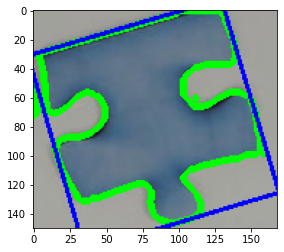

In [8]:
biggest_contour = max(contours, key = cv2.contourArea)
rect = cv2.minAreaRect(biggest_contour)
box_raw = cv2.boxPoints(rect)
box = np.int0(box_raw)
plt.imshow(cv2.drawContours(img1,[box],0,(0,0,255),2))

In [17]:
top_line_vector = box_raw[1] - box_raw[0]
top_line_vector = top_line_vector / np.linalg.norm(top_line_vector)
np.arccos(top_line_vector.dot(np.array([1, 0])))

0.29145689355335697

In [48]:
maxWidth = 30
maxHeight = 30
dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype = "float32")

# compute the perspective transform matrix and then apply it
M = cv2.getPerspectiveTransform(box.astype(np.float32), dst)
warped = cv2.warpPerspective(img_m1, M, (maxWidth, maxHeight))

top_horizon = warped[5]
bottom_horizon = warped[25]
left_verticle = warped[:,5]
right_verticle = warped[:,25]

In [94]:
def piece_to_warp()

def get_clusters(line):
    high_pixels = np.array([i for i in range(len(line)) if line[i] > 128])
    clusters = []
    cluster = []
    for i in range(len(high_pixels)):
        if (i > 0) and (high_pixels[i] > high_pixels[i-1] + 1):

            clusters.append(np.array(cluster))
            cluster = []
        else:
            cluster.append(high_pixels[i])
    clusters.append(np.array(cluster))
    return clusters

def get_line_type(line):
    if (line[2:-2] > 128).mean() > 0.83:
        return 'flat'
    
    clusters = get_clusters(line)
    clusters = [c for c in clusters if len(c) > 2]
    if len(clusters) > 1:
        return 'inward'
    else:
        return 'outward'

In [98]:
get_line_type(right_verticle)

'inward'

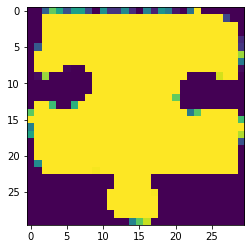

In [49]:
plt.imshow(warped)

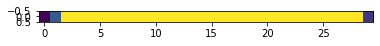

In [58]:
plt.imshow(top_horizon.reshape(1, -1))

In [71]:
# last_pixel = 0
# clusters = []
# cluster = []
# for i, pixel in enumerate(left_verticle):
#     if (last_pixel < 128 and pixel > 128):
#         cluster.append(i)
#     if (last_pixel > 128 and pixel < 128):
#         clusters.append(cluster)
#         cluster = []
# #     if(pixel > 128):
# #         cluster.append(i)
# if len(cluster) > 0:
#     clusters.append(cluster)

In [93]:
clusters

[array([1, 2, 3, 4, 5, 6, 7]), array([15, 16, 17, 18, 19, 20, 21, 22])]